# Machine Translation

In [1]:
!wget http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
!unzip -q spa-eng.zip

--2023-06-04 18:34:47--  http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.1.128, 108.177.121.128, 142.250.103.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.1.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2638744 (2.5M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   2.52M  --.-KB/s    in 0.02s   

2023-06-04 18:34:47 (146 MB/s) - ‘spa-eng.zip’ saved [2638744/2638744]



In [2]:
#Libraries
import random
import tensorflow as tf
import string
import re
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

### Files

In [3]:
#open our file
archivo = 'spa-eng/spa.txt'
with open(archivo) as f:
  lineas = f.read().split('\n')[:-1]
#pair sentences
parejas = []
for linea in lineas:
  #split english sentences from spanish
  eng,spa = linea.split("\t")
  #starting token and finishing token
  spa = "[BEG.] "+spa+"[END]"
  parejas.append((eng,spa))

In [4]:
parejas[:5]

[('Go.', '[BEG.] Ve.[END]'),
 ('Go.', '[BEG.] Vete.[END]'),
 ('Go.', '[BEG.] Vaya.[END]'),
 ('Go.', '[BEG.] Váyase.[END]'),
 ('Hi.', '[BEG.] Hola.[END]')]

In [5]:
#shuffle for improving training
random.shuffle(parejas)
#total length
len_total = len(parejas)
#choosing our validation set's length (15%)
num_val_muestras = int(0.15*len(parejas))

### Train, test and validation datasets

In [6]:
#choosing our train set's length (100%-2*(15%)=70%)
num_train_muestras = len(parejas)-2*num_val_muestras
#defining our train, test and validation datasets

#[from 0 to 70% of the data] = train
parejas_train = parejas[:num_train_muestras]
#[from 70% to 85% of the data] = validation
parejas_val = parejas[num_train_muestras:num_train_muestras+num_val_muestras]
#[from 85% to 100% of the data] = test
parejas_test = parejas[num_train_muestras+num_val_muestras:]

### Preprocessing

In [7]:
#taking of punctuation marks for spanish data
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[","")
strip_chars = strip_chars.replace("]","")

In [8]:
#evaluate chars regex
f"[{re.escape(strip_chars)}]"

'[!"\\#\\$%\\&\'\\(\\)\\*\\+,\\-\\./:;<=>\\?@\\\\\\^_`\\{\\|\\}\\~¿]'

In [9]:
#preprocessing our data 
def custom_standardization(input):
  lowcap = tf.strings.lower(input)
  return tf.strings.regex_replace(lowcap,f"[{re.escape(strip_chars)}]","")
#text vectorization to transform words into code
v_size = 15000
seq_len = 20
#english
source_vec = layers.TextVectorization(
    max_tokens=v_size,
    output_mode="int",
    output_sequence_length=seq_len,
)
#spanish (+1 token) and callback for standardization of the text to delete chars
target_vec = layers.TextVectorization(
    max_tokens=v_size,
    output_mode="int",
    output_sequence_length=seq_len+1,
    standardize=custom_standardization
)

In [10]:
#training our data
train_english_texts = [pareja[0] for pareja in parejas_train]
train_spanish_texts = [pareja[1] for pareja in parejas_train]
#asigning codes
source_vec.adapt(train_english_texts)
target_vec.adapt(train_spanish_texts)

### Datasets

In [11]:
#size of dataset batches
batch_size = 64
#dataset format
def format_dataset(eng,spa):
  #text vectorization to transform word into code after preprocessing
  eng = source_vec(eng)
  spa = target_vec(spa)
  #return structure of english and spanish sentences, and the output with the final token
  return({"english":eng,"spanish":spa[:,:-1],},spa[:,1:])

def make_dataset(parejas):
  eng_texts,spa_texts = zip(*parejas) #split english from spanish
  eng_texts = list(eng_texts)
  spa_texts = list(spa_texts)
  dataset = tf.data.Dataset.from_tensor_slices((eng_texts,spa_texts))
  dataset = dataset.batch(batch_size)
  dataset = dataset.map(format_dataset,num_parallel_calls=4) #map dataset using callback with paralization
  return dataset.shuffle(2048).prefetch(16).cache() #efficiency decisions

train_ds = make_dataset(parejas_train)
val__ds = make_dataset(parejas_val)

In [12]:
#visualization of the train dataset
print(list(train_ds.as_numpy_iterator())[50]);

({'english': array([[   6,   59,  257, ...,    0,    0,    0],
       [  21,  659,   39, ...,    0,    0,    0],
       [   5,  140, 4701, ...,    0,    0,    0],
       ...,
       [  15,    5,   32, ...,    0,    0,    0],
       [  34,   33,  227, ...,    0,    0,    0],
       [  17,  216,    3, ...,    0,    0,    0]]), 'spanish': array([[  2,   8, 194, ...,   0,   0,   0],
       [  2,  26,  24, ...,   0,   0,   0],
       [  2,  83,   4, ...,   0,   0,   0],
       ...,
       [  2, 128, 348, ...,   0,   0,   0],
       [  2, 135, 264, ...,   0,   0,   0],
       [  2,  41, 177, ...,   0,   0,   0]])}, array([[   8,  194,  517, ...,    0,    0,    0],
       [  26,   24,  742, ...,    0,    0,    0],
       [  83,    4, 1643, ...,    0,    0,    0],
       ...,
       [ 128,  348,    5, ...,    0,    0,    0],
       [ 135,  264,    6, ...,    0,    0,    0],
       [  41,  177,   59, ...,    0,    0,    0]]))


In [13]:
#shapes
for inputs,targets in train_ds.take(1):
  print(f"inputs['english'].shape: {inputs['english'].shape}")
  print(f"inputs['spanish'].shape: {inputs['spanish'].shape}")
  print(f"targets.shape: {targets.shape}")

inputs['english'].shape: (64, 20)
inputs['spanish'].shape: (64, 20)
targets.shape: (64, 20)


### RNN

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [15]:
#embedding dimensions (semantic layer)
embed_dim = 256
#latent dimensions
latent_dim = 1024

In [16]:
#Use GRU to compare with the Transformer
#input layer = english (conects with our dataset)
source = keras.Input(shape=(None,),dtype='int64',name='english')
#semantic layer, taking into account word by word
x = layers.Embedding(v_size,embed_dim,mask_zero=True)(source)
#last layer of the encoder
encoder_source = layers.Bidirectional(layers.GRU(latent_dim),merge_mode='sum')(x)

In [17]:
#same as above
past_target = keras.Input(shape=(None,), dtype='int64',name='spanish')
x = layers.Embedding(v_size,embed_dim,mask_zero=True)(past_target)
#create gru layer
decoder_gru = layers.GRU(latent_dim,return_sequences=True)
#input of the layer is spanish, and the initial state is the before result
x = decoder_gru(x,initial_state=encoder_source)
#reduce overfitting
x = layers.Dropout(0.5)(x)
#Dense layer (word by word)
target_next_step = layers.Dense(v_size,activation='softmax')(x)
#model
seq2seq_rnn = keras.Model([source,past_target],target_next_step)

In [18]:
#summary of the model
seq2seq_rnn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 english (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 spanish (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 256)    3840000     ['english[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 256)    3840000     ['spanish[0][0]']                
                                                                                              

In [19]:
#compile the model
seq2seq_rnn.compile(
    optimizer='rmsprop',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
history = seq2seq_rnn.fit(train_ds,epochs=30,validation_data=val__ds)

Epoch 1/30
1302/1302 [==============================] - 141s 94ms/step - loss: 5.2801 - accuracy: 0.2382 - val_loss: 4.3586 - val_accuracy: 0.3272
Epoch 2/30
1302/1302 [==============================] - 105s 81ms/step - loss: 4.1714 - accuracy: 0.3548 - val_loss: 3.6471 - val_accuracy: 0.4163
Epoch 3/30
1302/1302 [==============================] - 106s 81ms/step - loss: 3.6178 - accuracy: 0.4174 - val_loss: 3.2546 - val_accuracy: 0.4647
Epoch 4/30
1302/1302 [==============================] - 105s 81ms/step - loss: 3.2274 - accuracy: 0.4614 - val_loss: 2.9848 - val_accuracy: 0.5001
Epoch 5/30
1302/1302 [==============================] - 106s 81ms/step - loss: 2.9290 - accuracy: 0.4973 - val_loss: 2.7865 - val_accuracy: 0.5292
Epoch 6/30
1302/1302 [==============================] - 105s 81ms/step - loss: 2.6849 - accuracy: 0.5273 - val_loss: 2.6679 - val_accuracy: 0.5458
Epoch 7/30
1302/1302 [==============================] - 105s 81ms/step - loss: 2.4878 - accuracy: 0.5519 - val_loss: 2

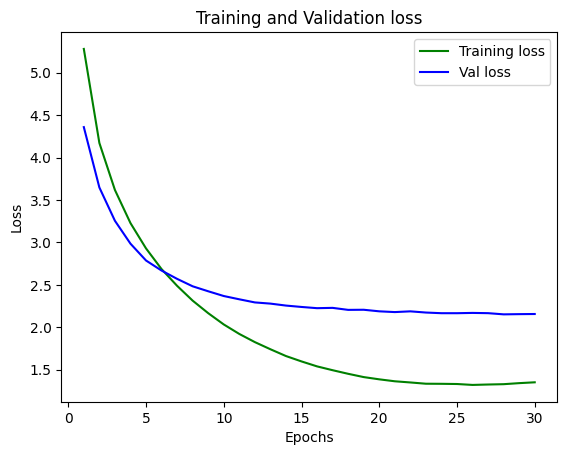

In [20]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,31)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Val loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

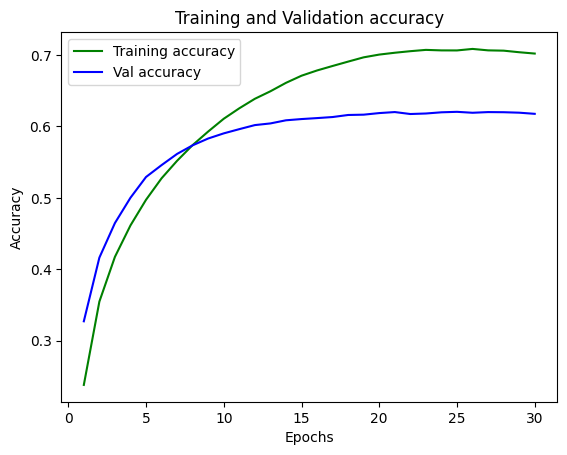

In [22]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,31)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='Val accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Using our RNN for MT

In [23]:
#spanish vocabulary, since we will get a code, not a word
spa_voc = target_vec.get_vocabulary()
#dictionary {code:word}
spa_index_lookup = dict(zip(range(len(spa_voc)),spa_voc))
#length of the sequence is 20
max_decoded_sentence_len = 20

In [24]:
#pairs for test
test_eng_texts = [pareja[0] for pareja in parejas_test]

In [25]:
len(test_eng_texts)

17844

In [26]:
# a simulation of what will happen
'''
input_sentence = random.choice(test_eng_texts)
print(input_sentence)

tokenized_input = source_vec([input_sentence])
print(tokenized_input)

decoded_sentence = '[BEG.]'
tokenized_output = target_vec([decoded_sentence])
print(tokenized_output)

next_tok_pred = seq2seq_rnn.predict([tokenized_input,tokenized_output])
print(next_tok_pred[0,0,:].shape)
print(next_tok_pred[0,0,:])

sampled_tok_idx = np.argmax(next_tok_pred[0,0,:])
print(sampled_tok_idx)

sampled_tok = spa_index_lookup[sampled_tok_idx]
print(sampled_tok)

decoded_sentence += " "+sampled_tok
print(decoded_sentence)

tokenized_output = target_vec([decoded_sentence])
print(tokenized_output)

next_tok_pred = seq2seq_rnn.predict([tokenized_input,tokenized_output])
print(next_tok_pred[0,1,:].shape)
print(next_tok_pred[0,1,:])

sampled_tok_idx = np.argmax(next_tok_pred[0,1,:])
print(sampled_tok_idx)

sampled_tok = spa_index_lookup[sampled_tok_idx]
print(sampled_tok)

decoded_sentence += " "+sampled_tok
print(decoded_sentence)
'''

'\ninput_sentence = random.choice(test_eng_texts)\nprint(input_sentence)\n\ntokenized_input = source_vec([input_sentence])\nprint(tokenized_input)\n\ndecoded_sentence = \'[BEG.]\'\ntokenized_output = target_vec([decoded_sentence])\nprint(tokenized_output)\n\nnext_tok_pred = seq2seq_rnn.predict([tokenized_input,tokenized_output])\nprint(next_tok_pred[0,0,:].shape)\nprint(next_tok_pred[0,0,:])\n\nsampled_tok_idx = np.argmax(next_tok_pred[0,0,:])\nprint(sampled_tok_idx)\n\nsampled_tok = spa_index_lookup[sampled_tok_idx]\nprint(sampled_tok)\n\ndecoded_sentence += " "+sampled_tok\nprint(decoded_sentence)\n\ntokenized_output = target_vec([decoded_sentence])\nprint(tokenized_output)\n\nnext_tok_pred = seq2seq_rnn.predict([tokenized_input,tokenized_output])\nprint(next_tok_pred[0,1,:].shape)\nprint(next_tok_pred[0,1,:])\n\nsampled_tok_idx = np.argmax(next_tok_pred[0,1,:])\nprint(sampled_tok_idx)\n\nsampled_tok = spa_index_lookup[sampled_tok_idx]\nprint(sampled_tok)\n\ndecoded_sentence += " "+s

In [27]:
#so we create a function which will help us decode our input
def decode_sequence(input_sentence):
  tokenized_input = source_vec([input_sentence])
  decoded_sentence = '[BEG.]'
  for i in range(max_decoded_sentence_len):
    tokenized_output = target_vec([decoded_sentence])
    next_tok_pred = seq2seq_rnn.predict([tokenized_input,tokenized_output])
    sampled_tok_idx = np.argmax(next_tok_pred[0,i,:])
    sampled_tok = spa_index_lookup[sampled_tok_idx]
    decoded_sentence += ' '+sampled_tok
    if sampled_tok == ['END']:
      break

  return decoded_sentence

test_eng_texts = [pareja[0] for pareja in parejas_test]
for _ in range(5):
  input_sentence = random.choice(test_eng_texts)
  print('.')
  print(input_sentence)
  print(decode_sequence(input_sentence))

.
We should get to Chicago by lunchtime.
1/1 [==============================] - 0s 29ms/step
[BEG.] deberíamos [UNK] a las [UNK]  [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK]
.
I shouldn't have wasted my time reading that.
1/1 [==============================] - 0s 25ms/step
[BEG.] no debí haber leído mi tiempo de eso[end]  [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK]
.
You need to exercise more.
1/1 [==============================] - 0s 41ms/step
[BEG.] necesitas hacer más[end]  [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK]
.
The sleeves of this coat have to be lengthened.
1/1 [==============================] - 0s 26ms/step
[BEG.] la [UNK] de esta camisa no tiene [UNK]  [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK]
.
This bridge was built two years ago.
1/1 [==============================] - 0s 28ms/step
[BEG.] este [UNK] fue hace dos años[end]  [UNK] [UNK] 

### Transformer

In [28]:
class TransformerEncoder(layers.Layer):
  def __init__(self,embed_dim,dense_dim,num_heads,**kwargs):
    super().__init__(**kwargs)
    self.embed_dim = embed_dim
    self.dense_dim = dense_dim
    self.num_heads = num_heads
    self.attention = layers.MultiHeadAttention(
        num_heads=num_heads,key_dim=embed_dim
    )
    #dense layer sequence
    self.dense_proj = keras.Sequential(
        [layers.Dense(dense_dim,activation='relu'),
        layers.Dense(embed_dim),]
    )
    self.layernorm_1 = layers.LayerNormalization()
    self.layernorm_2 = layers.LayerNormalization()

  def call(self,inputs,mask=None):
    #here the input generates our output
    #the mask is just for spanish sentences
    if mask is not None:
      mask = mask[:,tf.newaxis,:]
    attention_output = self.attention(inputs,inputs,attention_mask=mask)
    #we sum the input with the attention
    proj_input = self.layernorm_1(inputs+attention_output)
    #this is the output
    proj_output = self.dense_proj(proj_input)
    return self.layernorm_2(proj_input+proj_output)

  def get_config(self):
    config = super().get_config()
    config.update({
        'embed_dim':self.embed_dim,
        'num_heads':self.num_heads,
        'dense_dim':self.dense_dim,
    })
    return config

In [29]:
class TransformerDecoder(layers.Layer):
  def __init__(self,embed_dim,dense_dim,num_heads,**kwargs):
    super().__init__(**kwargs)
    self.embed_dim = embed_dim
    self.dense_dim = dense_dim
    self.num_heads = num_heads
    self.attention_1 = layers.MultiHeadAttention(
        num_heads=num_heads,key_dim=embed_dim
    )
    self.attention_2 = layers.MultiHeadAttention(
        num_heads=num_heads,key_dim=embed_dim
    )
    #dense layer sequence
    self.dense_proj = keras.Sequential(
        [layers.Dense(dense_dim,activation='relu'),
        layers.Dense(embed_dim),]
    )
    #3 layers of normalization
    self.layernorm_1 = layers.LayerNormalization()
    self.layernorm_2 = layers.LayerNormalization()
    self.layernorm_3 = layers.LayerNormalization()
    self.supports_masking = True

  def get_config(self):
    config = super().get_config()
    config.update({
        'embed_dim':self.embed_dim,
        'num_heads':self.num_heads,
        'dense_dim':self.dense_dim,
    })
    return config

  def get_causal_attention_mask(self,inputs):
    #this is the mask
    input_shape = tf.shape(inputs)
    batch_size,sequence_length = input_shape[0],input_shape[1]
    i = tf.range(sequence_length)[:,tf.newaxis]
    j = tf.range(sequence_length)
    mask = tf.cast(i >= j,dtype='int32')
    mask = tf.reshape(mask,(1,input_shape[1],input_shape[1]))
    mult = tf.concat([
        tf.expand_dims(batch_size,-1),
        tf.constant([1,1],dtype=tf.int32)],axis=0)
    return tf.tile(mask,mult)

  def call(self,inputs,encoder_outputs,mask=None):
    #this is the heart of the encoder
    causal_mask = self.get_causal_attention_mask(inputs)
    if mask is not None:
      padding_mask = tf.cast(
          mask[:,tf.newaxis,:],dtype='int32'
      )
      padding_mask = tf.minimum(padding_mask,causal_mask)
    #the first attention gets spanish
    attention_output_1 = self.attention_1(
        query=inputs,
        value=inputs,
        key=inputs,
        attention_mask=causal_mask
    )
    #we have our normalization layer
    attention_output_1 = self.layernorm_1(inputs+attention_output_1)
    #the second attention combines the real english input with the spanish output
    attention_output_2 = self.attention_2(
        query=attention_output_1,
        value=encoder_outputs,
        key=encoder_outputs,
        attention_mask=padding_mask,
    )
    #another normalization layer with feed forward (dense layer)
    attention_output_2 = self.layernorm_2(attention_output_1+attention_output_2)
    proj_output = self.dense_proj(attention_output_2)
    return self.layernorm_3(attention_output_2+proj_output)

In [30]:
#in addition with semantics vector, it goes together with the position
#this is different from the embedding from the RNN
class Positional_Embedding(layers.Layer):
  def __init__(self,sequence_length,input_dim,output_dim,**kwargs):
    super().__init__(**kwargs)
    self.token_embeddings = layers.Embedding(
        input_dim=input_dim,output_dim=output_dim
    )
    self.position_embeddings = layers.Embedding(
        input_dim=sequence_length,output_dim=output_dim
    )
    self.sequence_length = sequence_length
    self.input_dim = input_dim
    self.output_dim = output_dim

  def call(self,inputs):
    #last dimension
    length = tf.shape(inputs)[-1]
    #range
    positions = tf.range(start=0,limit=length,delta=1)
    embedded_tokens = self.token_embeddings(inputs)
    #it takes the index sequence
    embedded_positions = self.position_embeddings(positions)
    #our encoder sums up the tokens and the position
    return embedded_tokens+embedded_positions

  def compute_mask(self,inputs,mask=None):
    return tf.math.not_equal(inputs,0)

  def get_config(self):
    config = super(Positional_Embedding,self).get_config()
    config.update({
        'output_dim':self.output_dim,
        'sequence_length':self.sequence_length,
        'input_dim':self.input_dim,
    })
    return config  

In [31]:
embed_dim = 256
dense_dim = 2048
num_heads = 8

#the input is our english sentence
encoder_inputs = keras.Input(shape=(None,),dtype='int64',name='english')
#the embedding
x = Positional_Embedding(seq_len,v_size,embed_dim)(encoder_inputs)
#encoder with our pre-set variables and the input
encoder_outputs = TransformerEncoder(embed_dim,dense_dim,num_heads)(x)

#the output is our spanish sentence
decoder_inputs = keras.Input(shape=(None,),dtype='int64',name='spanish')
#similar configurations
x = Positional_Embedding(seq_len,v_size,embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim,dense_dim,num_heads)(x,encoder_outputs)
x = layers.Dropout(0.5)(x)
#we get the vector of the word
decoder_outputs = layers.Dense(v_size,activation='softmax')(x)

#we create our transformer
transformer = keras.Model([encoder_inputs,decoder_inputs],decoder_outputs)

In [32]:
transformer.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 english (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 spanish (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 positional__embedding (Positio  (None, None, 256)   3845120     ['english[0][0]']                
 nal_Embedding)                                                                                   
                                                                                                  
 positional__embedding_1 (Posit  (None, None, 256)   3845120     ['spanish[0][0]']          

In [33]:
transformer.compile(
    optimizer='rmsprop',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
history_transformer = transformer.fit(train_ds,epochs=30,validation_data=val__ds)

Epoch 1/30
1302/1302 [==============================] - 112s 77ms/step - loss: 4.4004 - accuracy: 0.3627 - val_loss: 3.4098 - val_accuracy: 0.4633
Epoch 2/30
1302/1302 [==============================] - 85s 66ms/step - loss: 3.3791 - accuracy: 0.4798 - val_loss: 2.9790 - val_accuracy: 0.5250
Epoch 3/30
1302/1302 [==============================] - 85s 66ms/step - loss: 3.0535 - accuracy: 0.5280 - val_loss: 2.8342 - val_accuracy: 0.5490
Epoch 4/30
1302/1302 [==============================] - 85s 66ms/step - loss: 2.8778 - accuracy: 0.5552 - val_loss: 2.7842 - val_accuracy: 0.5606
Epoch 5/30
1302/1302 [==============================] - 84s 65ms/step - loss: 2.7755 - accuracy: 0.5746 - val_loss: 2.7731 - val_accuracy: 0.5662
Epoch 6/30
1302/1302 [==============================] - 85s 65ms/step - loss: 2.7057 - accuracy: 0.5886 - val_loss: 2.7611 - val_accuracy: 0.5714
Epoch 7/30
1302/1302 [==============================] - 85s 66ms/step - loss: 2.6369 - accuracy: 0.6025 - val_loss: 2.7340 

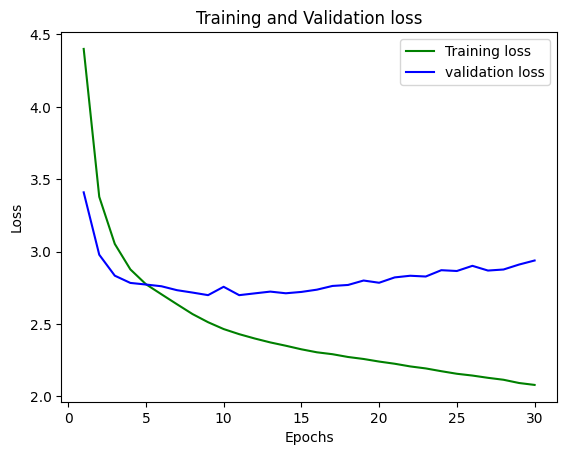

In [34]:
loss_train = history_transformer.history['loss']
loss_val = history_transformer.history['val_loss']
epochs = range(1,31)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

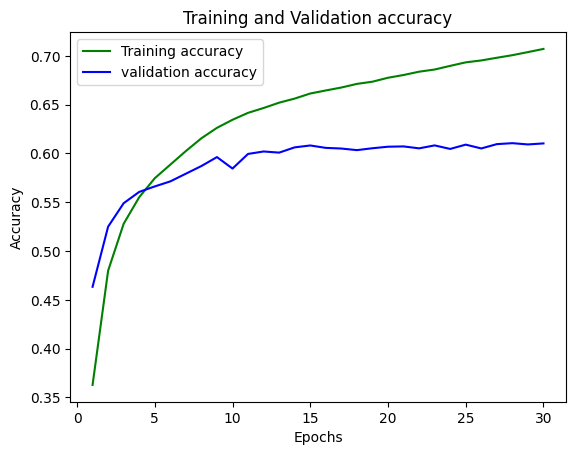

In [35]:
loss_train = history_transformer.history['accuracy']
loss_val = history_transformer.history['val_accuracy']
epochs = range(1,31)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Test transformer

In [36]:
def decode_sequence_Transformer(input_sentence):
  tokenized_input = source_vec([input_sentence])
  decoded_sentence = '[BEG.]'
  for i in range(max_decoded_sentence_len):
    tokenized_output = target_vec([decoded_sentence])[:,:-1]
    pred = transformer([tokenized_input,tokenized_output])
    sampled_tok_idx = np.argmax(pred[0,i,:])
    sampled_tok = spa_index_lookup[sampled_tok_idx]
    decoded_sentence += ' '+sampled_tok
    if sampled_tok == ['END']:
      break

  return decoded_sentence

test_eng_texts = [pareja[0] for pareja in parejas_test]
for _ in range(5):
  input_sentence = random.choice(test_eng_texts)
  print('.')
  print(input_sentence)
  print(decode_sequence_Transformer(input_sentence))

.
He loved the change.
[BEG.] Él quería el cambio[end]                
.
Nothing in the world is stronger than the will to survive.
[BEG.] no en el mundo es más fuerte que el mundo [UNK]         
.
Who gave you permission to do this?
[BEG.] quién te dio [UNK] para hacer esto[end]             
.
Tom ran to catch the train.
[BEG.] tom corrió hacia el tren hacia el tren[end]            
.
I've found the key.
[BEG.] he encontrado la llave[end]                
